In [722]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import softmax
import pickle
import pandas as pd

In [770]:
# Fake data - expected format!
#n_cal = 1000
#n_classes = 100
#n_test = 500
#pred_cal = softmax(np.random.rand(n_cal,n_classes), axis = 1)
#pred_test = softmax(np.random.rand(n_test,n_classes), axis = 1)
#true_cal = np.eye(n_classes)[np.random.choice(n_classes, n_cal)]
#true_test = np.eye(n_classes)[np.random.choice(n_classes, n_test)]

In [802]:
#with open('../../predictions/CIFAR10_cal_NLLLoss_sparsemax_proba.pickle', 'rb') as f:
#    pred_cal_1 = pickle.load(f)
#with open('../../predictions/CIFAR10_test_NLLLoss_sparsemax_proba.pickle', 'rb') as f:
#    pred_test_1 = pickle.load(f)
#with open('../../predictions/CIFAR10_cal_true.pickle', 'rb') as f:
#    true_cal = pickle.load(f)
#with open('../../predictions/CIFAR10_test_true.pickle', 'rb') as f:
#    true_test = pickle.load(f)

In [818]:
pred_label_test = np.argmax(pred_test, axis = 1)
true_label_test = np.argmax(true_test, axis = 1)
pred_max_test = np.max(pred_test,axis = 1)
test_results = pd.DataFrame({'true_label': true_label_test,
                             'pred_label': pred_label_test,
                             'prob': pred_max_test})
test_results['match'] = test_results.true_label==test_results.pred_label
test_results['std_prob'] = (test_results.prob - test_results.prob.mean())/test_results.prob.std()
#test_results['prob_bin'] = pd.qcut(test_results['prob'], q=4, labels=False,duplicates='drop')
#test_results.groupby('prob_bin')[['match','prob']].agg({'prob': 'max','match': 'mean'})

In [1028]:
# Get non-conformity scores
alpha = 0.1
pred_cal_path = '../../predictions/CIFAR10_cal_NLLLoss_softmax_proba.pickle'
pred_test_path = '../../predictions/CIFAR10_test_NLLLoss_softmax_proba.pickle'
true_cal_path = '../../predictions/CIFAR10_cal_true.pickle'
true_test_path = '../../predictions/CIFAR10_test_true.pickle'

def get_data(pred_cal_path, pred_test_path,true_cal_path, true_test_path):
    with open(pred_cal_path, 'rb') as f:
        pred_cal = pickle.load(f)
    with open(pred_test_path, 'rb') as f:
        pred_test = pickle.load(f)
    with open(true_cal_path, 'rb') as f:
        true_cal = pickle.load(f)
    with open(true_test_path, 'rb') as f:
        true_test = pickle.load(f)
    return pred_cal, pred_test, true_cal, true_test
    
def run_cp(pred_cal, pred_test, true_cal, true_test, alpha, plots = False, disallow_empty=False):
    def get_pvalue(preds):
            return np.array([((cal_scores>= el).sum() + 1)/(len(cal_scores) + 1) for el in preds])
    
    #def cp_classifier(pred_cal, true_cal, pred_test, true_test, method='naive',alpha=0.1):
    n_cal, n_classes = pred_cal.shape 
    n_test = true_test.shape[0]
    #print(f'{n_cal} calibration points')
    #print(f'{n_test} test points')
    #print(f'{n_classes} classes')
    
    # Get calibration quantile
    true_mask = true_cal.astype(bool)
    cal_scores = 1 - pred_cal[true_mask]
    #cal_scores = ((1 - pred_cal[true_mask])/(n_classes-pred_cal.astype(bool).sum(axis=1).reshape((n_cal,1)).T)).T
    q_level = np.ceil((n_cal+1)*(1-alpha))/n_cal
    qhat = np.quantile(cal_scores, q_level, method = 'higher') # check quantile method
    
    # test predictions
    test_scores = 1 - pred_test
    #alternative
    #test_scores = ((1 - pred_test)/(n_classes-pred_test.astype(bool).sum(axis=1).reshape((n_test,1))))
    test_match = test_scores<= qhat
    if disallow_empty:
        helper = np.zeros(pred_test[(test_match.sum(axis = 1)==0)].shape)
        helper[np.arange(helper.shape[0]),pred_test[(test_match.sum(axis = 1)==0)].argmax(axis = 1)]=1
        test_match[(test_match.sum(axis = 1)==0)] = helper
    # get p-values 
    test_pvalues = np.apply_along_axis(get_pvalue,1,test_scores)
    p_values_cal = get_pvalue(cal_scores)
    
    # Set size and scores distribution
    set_size = test_match.sum(axis = 1)
    if plots:   
        fig, axs = plt.subplots(1,2,figsize=(12,6))
        axs[0].hist(set_size)
        axs[0].vlines(set_size.mean(),0,max(np.histogram(set_size, bins=10)[0])+10, color='black')
        axs[0].text(set_size.mean()*1.02,max(np.histogram(set_size, bins=10)[0]-10)*0.95,  f'S = {set_size.mean()}', color='black',fontweight='bold')
        axs[0].set_title('Set Size Distribution')
        
        axs[1].hist(cal_scores)
        axs[1].vlines(qhat,0,max(np.histogram(cal_scores, bins=10)[0])+10, color='black')
        axs[1].text(qhat*1.02,max(np.histogram(cal_scores, bins=10)[0]-10)*0.95, f'q={qhat:.3f}', color='black',fontweight='bold')
        axs[1].set_title('Non-Conf Scores Distribution')
        plt.show()
    
    coverage = test_match[true_test.astype(bool)].sum()/n_test
    #print(f'Coverage:{coverage}')
    class_coverage = (test_match & true_test).sum(axis = 0)/true_test.sum(axis=0)
    
    set_size = test_match.sum(axis = 1)
    #print(f'Avg set size:{set_size.mean()}')
    class_size = true_test.copy()
    class_size[class_size==1]=test_match.sum(axis = 1)
    class_size = class_size.sum(axis=0)/true_test.sum(axis=0)

    if plots:
    # Class-wise metrics
        fig, axs = plt.subplots(1,2,figsize=(12,6))
        # add labels?
        axs[0].bar(np.arange(n_classes),class_coverage)
        axs[0].hlines(coverage,0,n_classes-1, color='black')
        axs[0].hlines(1-alpha,0,n_classes-1, color='green')
        axs[0].text(0,coverage, f'Emp. cov. = {coverage:.2f}', color='black',fontweight='bold')
        axs[0].text(0,1-alpha, f'Theo. cov. = {1-alpha:.2f}', color='green',fontweight='bold')
        axs[0].set_title('Class Conditional Coverage')
        
        
        axs[1].bar(np.arange(n_classes),class_size)
        axs[1].hlines(set_size.mean(),0,100, color='black')
        axs[1].text(0,set_size.mean(), f'S={set_size.mean():.3f}', color='black',fontweight='bold')
        axs[1].set_title('Class Avg Set size')
        
        plt.show()
    
    # Observed fuzziness
    of = np.ma.array(test_pvalues, mask = true_test).mean(axis=1).data.mean()
    #print(f'OF={of:.4f}')
    return test_match, coverage, set_size.mean()

In [1061]:
# Get non-conformity scores
alpha = 0.1
pred_cal_path = '../../predictions/CIFAR10_cal_FYLoss_softmax_proba.pickle'
pred_test_path = '../../predictions/CIFAR10_test_FYLoss_softmax_proba.pickle'
true_cal_path = '../../predictions/CIFAR10_cal_true.pickle'
true_test_path = '../../predictions/CIFAR10_test_true.pickle'
pred_cal, pred_test, true_cal, true_test = get_data(pred_cal_path, pred_test_path,true_cal_path, true_test_path)

In [1062]:
n_cal, n_classes = pred_cal.shape 
n_test = true_test.shape[0]
#print(f'{n_cal} calibration points')
#print(f'{n_test} test points')
#print(f'{n_classes} classes')

# Get calibration quantile
true_mask = true_cal.astype(bool)
cal_scores = 1 - pred_cal[true_mask]
#cal_scores = ((1 - pred_cal[true_mask])/(n_classes-pred_cal.astype(bool).sum(axis=1).reshape((n_cal,1)).T)).T
q_level = np.ceil((n_cal+1)*(1-alpha))/n_cal
qhat = np.quantile(cal_scores, q_level, method = 'higher') # check quantile method

# test predictions
test_scores = 1 - pred_test
#alternative
#test_scores = ((1 - pred_test)/(n_classes-pred_test.astype(bool).sum(axis=1).reshape((n_test,1))))
test_match = test_scores<= qhat
# get p-values 
#test_pvalues = np.apply_along_axis(get_pvalue,1,test_scores)
#p_values_cal = get_pvalue(cal_scores)

# Set size and scores distribution
#set_size = test_match.sum(axis = 1)

In [1063]:
run_cp(pred_cal, pred_test, true_cal, true_test, alpha, plots = False)

(array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False,  True, False],
        [False, False, False, ..., False,  True, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False,  True, False, ..., False, False, False],
        [False, False, False, ...,  True, False, False]]),
 0.9055,
 1.2133)

In [1064]:
pred_cal, pred_test, true_cal, true_test = get_data(pred_cal_path, pred_test_path,true_cal_path, true_test_path)
alphas = np.linspace(0.001,0.4,20)
test_matches_soft = []
coverages_soft = []
avg_sizes_soft = []
for alpha in alphas:
    test_match, coverage, avg_size = run_cp(pred_cal, pred_test, true_cal, true_test, alpha, plots = False)
    test_matches_soft.append(test_match)
    coverages_soft.append(coverage)
    avg_sizes_soft.append(avg_size)

In [1065]:
# Get non-conformity scores
alpha = 0.1
pred_cal_path = '../../predictions/CIFAR10_cal_FYLoss_sparsemax_proba.pickle'
pred_test_path = '../../predictions/CIFAR10_test_FYLoss_sparsemax_proba.pickle'
true_cal_path = '../../predictions/CIFAR10_cal_true.pickle'
true_test_path = '../../predictions/CIFAR10_test_true.pickle'

In [1066]:
pred_cal, pred_test, true_cal, true_test = get_data(pred_cal_path, pred_test_path,true_cal_path, true_test_path)
alphas = np.linspace(0.001,0.4,20)
test_matches_sparse = []
coverages_sparse = []
avg_sizes_sparse = []
for alpha in alphas:
    test_match, coverage, avg_size = run_cp(pred_cal, pred_test, true_cal, true_test, alpha, plots = False)
    test_matches_sparse.append(test_match)
    coverages_sparse.append(coverage)
    avg_sizes_sparse.append(avg_size)

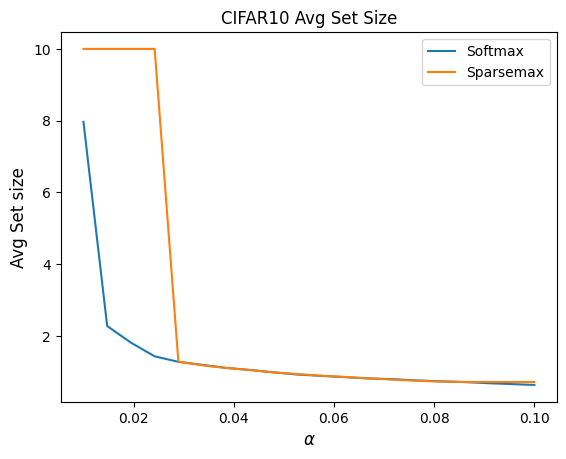

In [1096]:
plt.plot(alphas,avg_sizes_soft, label = 'Softmax')
plt.plot(alphas,avg_sizes_sparse, label = 'Sparsemax')
plt.legend()
plt.xlabel(r'$\alpha$',fontsize=12)
plt.ylabel('Avg Set size', fontsize=12)
plt.title('CIFAR10 Avg Set Size')
plt.show()

In [867]:
n_test = pred_test.shape[0]
pred_match = pred_test>0
pred_match[true_test.astype(bool)].sum()/n_test

0.9297

In [1101]:
pred_cal_path = '../../predictions/CIFAR10_cal_FYLoss_logits_proba.pickle'
pred_test_path = '../../predictions/CIFAR10_test_FYLoss_logits_proba.pickle'
true_cal_path = '../../predictions/CIFAR10_cal_true.pickle'
true_test_path = '../../predictions/CIFAR10_test_true.pickle'
pred_cal, pred_test, true_cal, true_test = get_data(pred_cal_path, pred_test_path,true_cal_path, true_test_path)

In [1102]:
from entmax import sparsemax
import torch

In [1103]:
betas = np.linspace(0.1,1.5,20)
coverages = []
avg_sizes = []
for beta in betas:
    sparse_pred = sparsemax(torch.tensor(pred_test)*beta, dim = -1)
    sparse_pred = sparse_pred.numpy()
    pred_match = sparse_pred>0
    coverages.append(pred_match[true_test.astype(bool)].sum()/n_test)
    avg_sizes.append(pred_match.sum(axis = 1).mean())

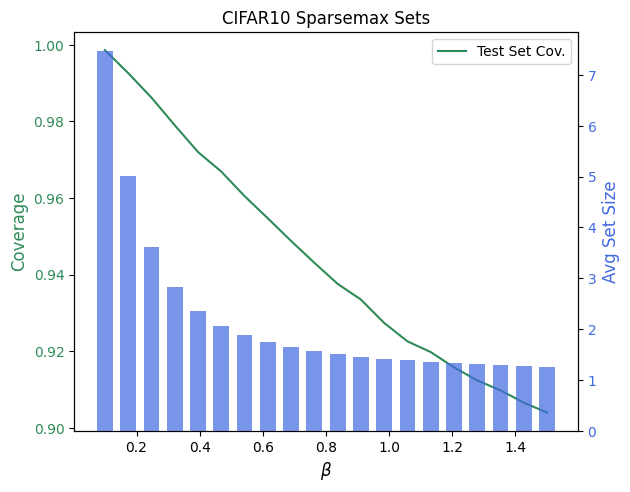

In [1112]:
fig, ax1 = plt.subplots()

color = 'seagreen'
ax1.set_xlabel(r'$\beta$', fontsize=12)
ax1.set_ylabel('Coverage', color=color, fontsize=12)
ax1.plot(betas, coverages, color=color, label = 'Test Set Cov.')
#ax1.plot(alphas, 1-alphas, color='black', linestyle='dashed',label = 'Theoretical Bound')
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend()
ax2 = ax1.twinx()  # instantiate a second Axes that shares the same x-axis

color = 'royalblue'
ax2.set_ylabel('Avg Set Size', color=color, fontsize=12)  # we already handled the x-label with ax1
ax2.bar(betas, avg_sizes,width=0.05, color=color, alpha=0.7)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title('CIFAR10 Sparsemax Sets')
plt.show()

In [1136]:
pred_cal_path = '../../predictions/MNIST_cal_NLLLoss_softmax_proba.pickle'
pred_test_path = '../../predictions/MNIST_test_NLLLoss_softmax_proba.pickle'
true_cal_path = '../../predictions/MNIST_cal_true.pickle'
true_test_path = '../../predictions/MNIST_test_true.pickle'
pred_cal_path_sparse = '../../predictions/CIFAR100_cal_NLLLoss_sparsemax_proba.pickle'
pred_test_path_sparse = '../../predictions/CIFAR100_test_NLLLoss_sparsemax_proba.pickle'
true_cal_path_sparse = '../../predictions/CIFAR100_cal_true.pickle'
true_test_path_sparse = '../../predictions/CIFAR100_test_true.pickle'
pred_cal, pred_test, true_cal, true_test = get_data(pred_cal_path, pred_test_path,true_cal_path, true_test_path)
pred_cal_sparse, pred_test_sparse, true_cal_sparse, true_test_sparse = get_data(pred_cal_path_sparse, 
                                                                                pred_test_path_sparse,
                                                                                true_cal_path_sparse, 
                                                                                true_test_path_sparse)

In [1137]:
alpha = 0.1
n_cal = pred_cal.shape[0]
n_test = pred_test.shape[0]
true_mask = true_cal.astype(bool)
cal_scores = 1 - pred_cal[true_mask]
cal_scores_sparse = 1 - pred_cal_sparse[true_mask]

q_level = np.ceil((n_cal+1)*(1-alpha))/n_cal

qhat = np.quantile(cal_scores, q_level, method = 'higher')
qhat_sparse = np.quantile(cal_scores_sparse, q_level, method = 'higher')

test_scores = 1 - pred_test
test_scores_sparse = 1 - pred_test_sparse

test_match = test_scores<= qhat
test_match_sparse = test_scores_sparse<= qhat_sparse

IndexError: boolean index did not match indexed array along dimension 1; dimension is 100 but corresponding boolean dimension is 10

Text(0.5, 1.0, 'Non-Conformity Scores Distribution')

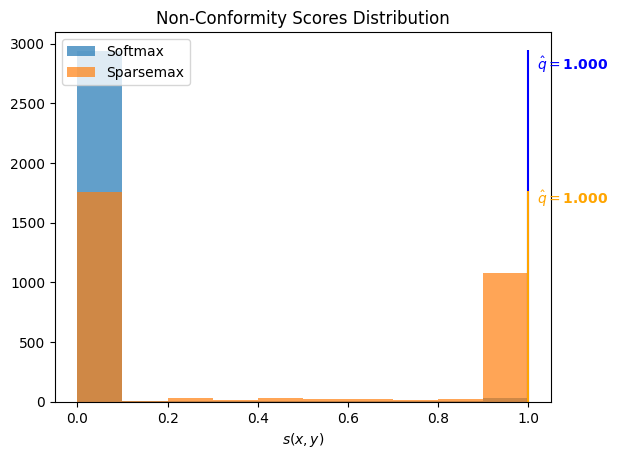

In [1138]:
fig, axs = plt.subplots()
axs.hist(cal_scores,alpha=0.7, bins=10,label = 'Softmax')
axs.hist(cal_scores_sparse,alpha=0.7,bins=10,label = 'Sparsemax')
axs.legend(loc='upper left')
axs.vlines(qhat,0,max(np.histogram(cal_scores, bins=10)[0])+10, color='blue')
axs.text(qhat*1.02,max(np.histogram(cal_scores, bins=10)[0]-10)*0.95, r'$\hat{q}=$'+f'{qhat:.3f}', color='blue',fontweight='bold')
axs.set_xlabel(r'$s(x,y)$')
axs.vlines(qhat_sparse,0,max(np.histogram(cal_scores_sparse, bins=10)[0])+10, color='orange')
axs.text(qhat_sparse*1.02,max(np.histogram(cal_scores_sparse, bins=10)[0]-10)*0.95, r'$\hat{q}=$'+f'{qhat_sparse:.3f}', color='orange',fontweight='bold')
axs.set_title('Non-Conformity Scores Distribution')

In [1139]:
#sparse_pred = sparsemax(torch.tensor(pred_test), dim = -1)
#sparse_pred = sparse_pred.numpy()
#sparse_cal = sparsemax(torch.tensor(pred_cal), dim = -1)
#sparse_cal = sparse_cal.numpy()
alphas = np.linspace(0.01,0.1,20)
coverages = []
avg_sizes = []
q_hats = []
n_cal = pred_cal.shape[0]
n_test = pred_test.shape[0]
true_mask = true_cal.astype(bool)
cal_scores = 1 - pred_cal[true_mask]
for alpha in alphas:
    q_level = np.ceil((n_cal+1)*(1-alpha))/n_cal
    qhat = np.quantile(cal_scores, q_level, method = 'higher')
    test_scores = 1 - pred_test
    test_match = test_scores<= qhat
    #helper = np.zeros(pred_test[(test_match.sum(axis = 1)==0)].shape)
    #helper[np.arange(helper.shape[0]),pred_test[(test_match.sum(axis = 1)==0)].argmax(axis = 1)]=1
    #test_match[(test_match.sum(axis = 1)==0)] = helper
    coverages.append(test_match[true_test.astype(bool)].sum()/n_test)
    avg_sizes.append(test_match.sum(axis = 1).mean())
    q_hats.append(qhat)

In [1140]:
results_soft = pd.DataFrame({'alpha':alphas,
                             'qs': q_hats,
                             'coverage':coverages,
                             'avg_size': avg_sizes})


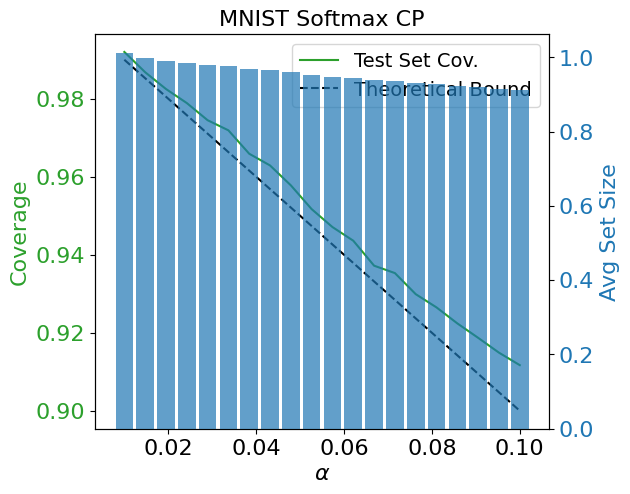

In [1142]:
fig, ax1 = plt.subplots()

color = 'tab:green'
ax1.set_xlabel(r'$\alpha$', fontsize=16)
ax1.set_ylabel('Coverage', color=color, fontsize=16)
ax1.plot(alphas, coverages, color=color, label = 'Test Set Cov.')
ax1.plot(alphas, 1-alphas, color='black', linestyle='dashed',label = 'Theoretical Bound')
ax1.tick_params(axis='y', labelcolor=color,labelsize=16)
ax1.tick_params(axis='x',labelsize=16)

ax1.legend(fontsize=14)
ax2 = ax1.twinx()  # instantiate a second Axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Avg Set Size', color=color, fontsize=16)  # we already handled the x-label with ax1
ax2.bar(alphas, avg_sizes,width=0.004, color=color, alpha=0.7)
ax2.tick_params(axis='y', labelcolor=color,labelsize=16)
#ax2.set_yticks([0.02, 0.04,0.06,0.08,0.1],fontsize=20)

fig.tight_layout()
plt.title('MNIST Softmax CP',fontsize=16)
plt.show()

In [875]:
alpha = 0.1
pred_cal_path = '../../predictions/CIFAR10_cal_FYLoss_sparsemax_proba.pickle'
pred_test_path = '../../predictions/CIFAR10_test_FYLoss_sparsemax_proba.pickle'
true_cal_path = '../../predictions/CIFAR10_cal_true.pickle'
true_test_path = '../../predictions/CIFAR10_test_true.pickle'

pred_cal, pred_test, true_cal, true_test = get_data(pred_cal_path, pred_test_path,true_cal_path, true_test_path)
def run_cp(pred_cal, pred_test, true_cal, true_test, alpha, plots = False):

SyntaxError: incomplete input (3927372296.py, line 8)

In [1034]:
pred_cal_path = '../../predictions/CIFAR10_cal_NLLLoss_softmax_proba.pickle'
pred_test_path = '../../predictions/CIFAR10_test_NLLLoss_softmax_proba.pickle'
true_cal_path = '../../predictions/CIFAR10_cal_true.pickle'
true_test_path = '../../predictions/CIFAR10_test_true.pickle'
datasets = ['MNIST','CIFAR10','CIFAR100']
losses = ['NLLLoss','FYLoss']
scores = ['softmax','sparsemax']
alphas = [0.1,0.05,0.01]
results = {data:{'test_true': None,
                  'predictions':[]} for data in datasets}
for key, value in results.items():
    true_cal_path = f'../../predictions/{key}_cal_true.pickle'
    true_test_path = f'../../predictions/{key}_test_true.pickle'  
    for loss in losses:
        for score in scores:
            pred_cal_path = f'../../predictions/{key}_cal_{loss}_{score}_proba.pickle'
            pred_test_path = f'../../predictions/{key}_test_{loss}_{score}_proba.pickle'
            pred_cal, pred_test, true_cal, true_test = get_data(pred_cal_path, pred_test_path,true_cal_path, true_test_path)
            value['predictions'].append({'loss':loss,
                                        'score':score,
                                        'cp_preds':[]})
            for alpha in alphas:
                print(f'{key}-{loss}-{score}-{alpha}')
                pred_sets = run_cp(pred_cal, pred_test, true_cal, true_test, alpha)
                value['predictions'][-1]['cp_preds'].append({'alpha':alpha,
                                                             'sets':pred_sets})

MNIST-NLLLoss-softmax-0.1
MNIST-NLLLoss-softmax-0.05
MNIST-NLLLoss-softmax-0.01
MNIST-NLLLoss-sparsemax-0.1
MNIST-NLLLoss-sparsemax-0.05
MNIST-NLLLoss-sparsemax-0.01
MNIST-FYLoss-softmax-0.1
MNIST-FYLoss-softmax-0.05
MNIST-FYLoss-softmax-0.01
MNIST-FYLoss-sparsemax-0.1
MNIST-FYLoss-sparsemax-0.05
MNIST-FYLoss-sparsemax-0.01
CIFAR10-NLLLoss-softmax-0.1
CIFAR10-NLLLoss-softmax-0.05
CIFAR10-NLLLoss-softmax-0.01
CIFAR10-NLLLoss-sparsemax-0.1
CIFAR10-NLLLoss-sparsemax-0.05
CIFAR10-NLLLoss-sparsemax-0.01
CIFAR10-FYLoss-softmax-0.1
CIFAR10-FYLoss-softmax-0.05
CIFAR10-FYLoss-softmax-0.01
CIFAR10-FYLoss-sparsemax-0.1
CIFAR10-FYLoss-sparsemax-0.05
CIFAR10-FYLoss-sparsemax-0.01
CIFAR100-NLLLoss-softmax-0.1
CIFAR100-NLLLoss-softmax-0.05
CIFAR100-NLLLoss-softmax-0.01
CIFAR100-NLLLoss-sparsemax-0.1
CIFAR100-NLLLoss-sparsemax-0.05
CIFAR100-NLLLoss-sparsemax-0.01
CIFAR100-FYLoss-softmax-0.1
CIFAR100-FYLoss-softmax-0.05
CIFAR100-FYLoss-softmax-0.01
CIFAR100-FYLoss-sparsemax-0.1
CIFAR100-FYLoss-sparsema

In [812]:
cal_labels = true_cal.argmax(axis = 1)
test_labels = true_test.argmax(axis = 1)

In [796]:
# Set RAPS regularization parameters (larger lam_reg and smaller k_reg leads to smaller sets)
lam_reg = 0.5
k_reg = 1
disallow_zero_sets = True # Set this to False in order to see the coverage upper bound hold
rand = False # Set this to True in order to see the coverage upper bound hold
reg_vec = np.array(k_reg*[0,] + (pred_cal.shape[1]-k_reg)*[lam_reg,])[None,:]

In [713]:
# Get scores. calib_X.shape[0] == calib_Y.shape[0] == n
cal_pi = pred_cal.argsort(1)[:,::-1]; 
cal_srt = np.take_along_axis(pred_cal,cal_pi,axis=1)

cal_srt_reg = cal_srt + reg_vec
cal_L = np.where(cal_pi == cal_labels[:,None])[1]
cal_scores = cal_srt_reg.cumsum(axis=1)[np.arange(n_cal),cal_L] - np.random.rand(n_cal)*cal_srt_reg[np.arange(n_cal),cal_L]
# Get the score quantile
qhat = np.quantile(cal_scores, np.ceil((n_cal+1)*(1-alpha))/n_cal, method='higher')
# Deploy
n_val = true_test.shape[0]
val_pi = pred_test.argsort(1)[:,::-1]
val_srt = np.take_along_axis(pred_test,val_pi,axis=1)
val_srt_reg = val_srt + reg_vec
val_srt_reg_cumsum = val_srt_reg.cumsum(axis=1)
indicators = (val_srt_reg.cumsum(axis=1) - np.random.rand(n_val,1)*val_srt_reg) <= qhat if rand else val_srt_reg.cumsum(axis=1) - val_srt_reg <= qhat
if disallow_zero_sets: indicators[:,0] = True
prediction_sets = np.take_along_axis(indicators,val_pi.argsort(axis=1),axis=1)

In [714]:
empirical_coverage = prediction_sets[np.arange(n_test),test_labels].mean()
print(f"The empirical coverage is: {empirical_coverage}")
print(f"The quantile is: {qhat}")

The empirical coverage is: 0.9119
The quantile is: 5.579866867683232


In [715]:
prediction_sets.sum(axis=1).mean()

11.0

(array([    0.,     0.,     0.,     0.,     0., 10000.,     0.,     0.,
            0.,     0.]),
 array([10.5, 10.6, 10.7, 10.8, 10.9, 11. , 11.1, 11.2, 11.3, 11.4, 11.5]),
 <BarContainer object of 10 artists>)

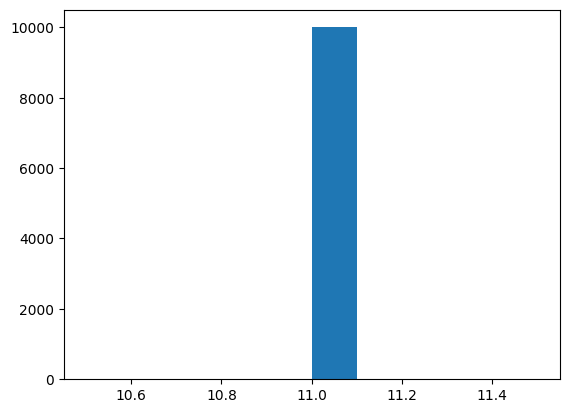

In [716]:
plt.hist(prediction_sets.sum(axis=1))

(array([2664.,  158.,   59.,   44.,   29.,   18.,   12.,    7.,    4.,
           5.]),
 array([1.45588822e-03, 4.90543703e+00, 9.80941818e+00, 1.47133993e+01,
        1.96173805e+01, 2.45213616e+01, 2.94253428e+01, 3.43293239e+01,
        3.92333050e+01, 4.41372862e+01, 4.90412673e+01]),
 <BarContainer object of 10 artists>)

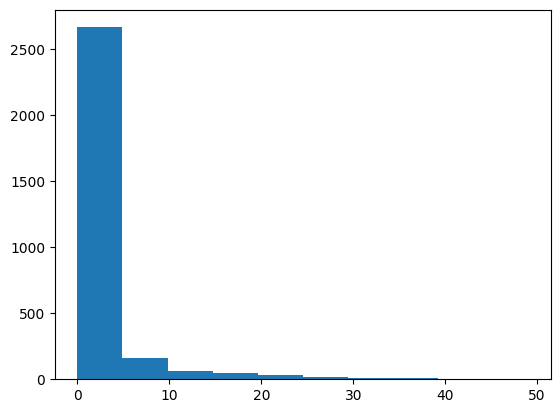

In [717]:
plt.hist(cal_scores)